In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow-addons
import tensorflow as tf


In [ ]:
cd /content/drive/My Drive/Potato/Spectral_Images


In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras import Model
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
path = "/content/drive/My Drive/Potato/Spectral_Images/Near_Infrared_Channel/Train_Images"
annot = "/content/drive/MyDrive/Potato/Spectral_Images/Labels/Train_Labels_XML/"

Image_017.jpg


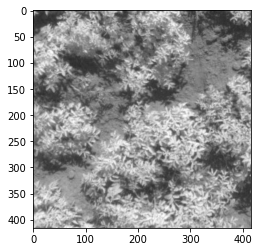

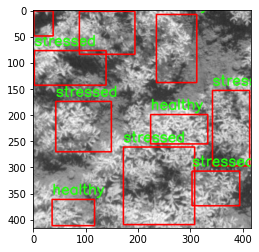

In [ ]:
        Index=17
        filename = "Image_0"+str(Index)+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
        plt.imshow(img)
        for rows in df.iterrows():
            x1 = int(rows[1][1])
            y1 = int(rows[1][2])
            x2 = int(rows[1][3])
            y2 = int(rows[1][4])
            classes = rows[1][5]
            image = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
            cv2.putText(image, str(classes), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        plt.figure()
        plt.imshow(img)

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

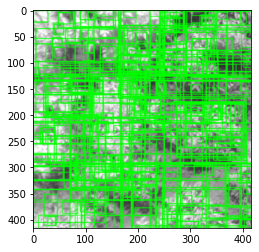

In [ ]:
im = cv2.imread(os.path.join(path,"Image_005.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)


In [ ]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
label = ['stressed','healthy']
label_dict = dict()

for i,j in enumerate(label):
    label_dict[j] = i
label_dict

{'stressed': 0, 'healthy': 1}

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("Image"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for rows in df.iterrows():
              x1 = int(rows[1][1])
              y1 = int(rows[1][2])
              x2 = int(rows[1][3])
              y2 = int(rows[1][4])
              classed = str(rows[1][5])
              gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2,"classes":classed})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.70:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(label_dict[classed])
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 Image_003.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_003.jpg
1 Image_005.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_005.jpg
2 Image_004.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_004.jpg
3 Image_002.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_002.jpg
4 Image_014.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_014.jpg
5 Image_010.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_010.jpg
6 Image_012.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_012.jpg
7 Image_007.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_007.jpg
8 Image_017.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_017.jpg
9 Image_006.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_006.jpg
10 Image_009.jpg
index 1 is out of bounds for axis 0 with size 1
error in Image_009.jpg
11 Image_011.jpg
index 1 is out of bounds 

In [ ]:
X_new = np.array(train_images)
Y_new = np.array(train_labels)

In [ ]:
Y_new

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [ ]:
model.summary()
model.fit(X_new,Y_new,batch_size = 8,epochs = 1, verbose = 1,validation_split=.05,shuffle = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(Y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K



In [ ]:
K.clear_session()
trdata = ImageDataGenerator()
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator()
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

In [ ]:
image = cv2.imread(os.path.join(path,'Image_004.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)